# TL;DR In depth Analysis

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
wikihow_subset = pd.read_csv('./datasets/wikihow_sep_subset.csv')

In [3]:
wikihow_subset.head(3)

,text_id,sentence,is_summary,words,title,sentence_len,tfidf_score,title_similarity,title_sim_categories,help,...,want,many,ask,good,find,work,go,include,important,know
0,0,Sell yourself first,yes,"['Sell', 'yourself', 'first']",How to Sell Fine Art Online,3,1.725841,0.828910,Strong,0,...,0,0,0,0,0,0,0,0,0,0
1,0,"Before doing anything else, stop and sum up yo...",no,"['Before', 'doing', 'anything', 'else,', 'stop...",How to Sell Fine Art Online,12,3.421057,0.806864,Strong,0,...,0,0,0,0,0,0,0,0,0,0
2,0,"Now, think about how to translate that to an o...",no,"['Now,', 'think', 'about', 'how', 'to', 'trans...",How to Sell Fine Art Online,11,3.064425,0.857768,Strong,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Factorize `is_summary`
wikihow_subset['summary_id'] = wikihow_subset['is_summary'].apply(lambda x: 1 if x == 'yes' else 0)

In [5]:
# Features to keep (for now)
features = wikihow_subset[['text_id','sentence', 'summary_id','sentence_len','tfidf_score', 'title_similarity']]

In [6]:
# Value counts of the classes to get an idea of the null accuracy
features.summary_id.value_counts()

0    83438
1    16562
Name: summary_id, dtype: int64

In [7]:
null_accuracy = 83438/(16562+83438)
null_accuracy

0.83438

## Transforming Sentences into DTMs 

In [8]:
from sklearn.model_selection import train_test_split
X = features['sentence']
y = features['summary_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))
Xtrain_dtm = vectorizer.fit_transform(X_train)
Xtrain_dtm_dense = Xtrain_dtm.toarray() 
Xtrain_dtm_dense

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vectorizer.transform(X_test)
X_test_dtm

<30000x291782 sparse matrix of type '<class 'numpy.int64'>'
	with 709570 stored elements in Compressed Sparse Row format>

### Using word counts to find min_df 

In [11]:
feature_mat = Xtrain_dtm_dense[:1000]
for document in feature_mat:
    for word_index in range(len(document)):
        if document[word_index] > 1:
            document[word_index] = 1 

In [12]:
word_matrix = pd.DataFrame(data=feature_mat)

In [13]:
word_occurence_by_doc = word_matrix.sum(axis=0)

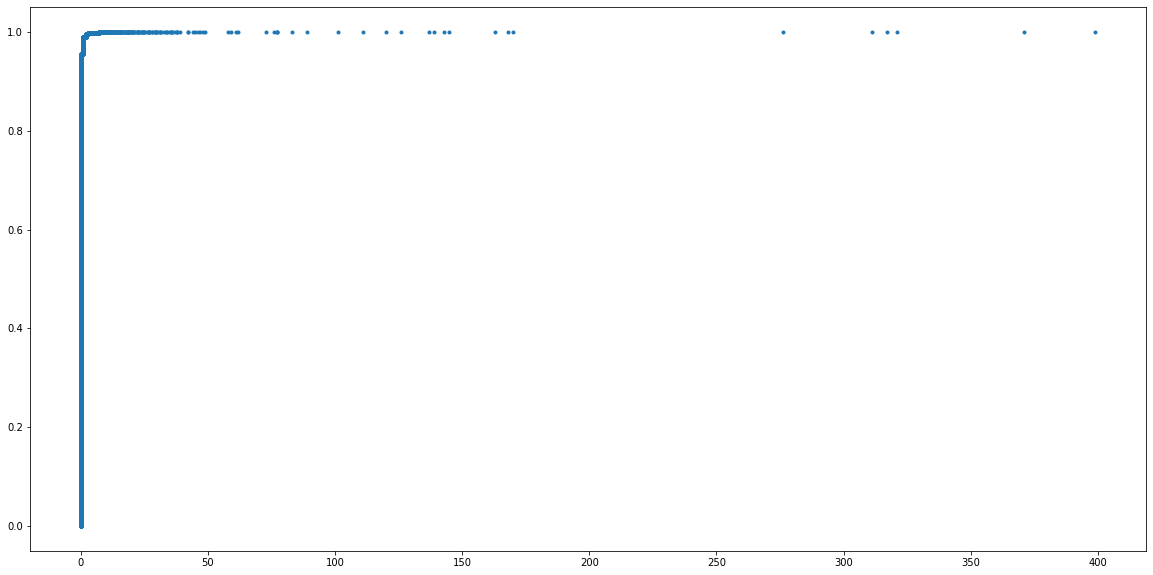

In [14]:
plt.figure(figsize=(20,10))
x = np.sort(word_occurence_by_doc)
y = np.arange(1, len(x) + 1)/len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')

looks like min_df here is around 0.96

In [15]:
X_test_dtm_tune1 = vectorizer.transform(X_test)
X_test_dtm_tune1

<30000x291782 sparse matrix of type '<class 'numpy.int64'>'
	with 709570 stored elements in Compressed Sparse Row format>

## Using Multinomial Naive Bayes

In [16]:
#Initializing MultinomialNB with default params
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [17]:
# train the model using X_train_dtm
nb.fit(Xtrain_dtm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [18]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

In [19]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8515333333333334

Our model performs slightly better than the null accuracy, we will need to do some parameter tuning and add some features in order to improve it.

In [20]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[24909,    51],
       [ 4403,   637]])

In [21]:
# false positive summaries (non summaries incorrectly classified as summaries)
X_test[y_pred_class > y_test].head()

149      Contemporary short story masters 1950 Present ...
36838                             Consider his perspective
87607                              Use fluoride toothpaste
26438                       Avoid foods with lots of carbs
11468                              Recap your hCG solution
Name: sentence, dtype: object

In [22]:
# false negative summaries (summaries incorrectly classified as non summaries)
X_test[y_pred_class < y_test].head()

19864    Cough or laugh during your ultrasound appointment
63120                  Monitor newborns with extra caution
35795                                 Drink more green tea
575      Choose the same last name as your parent s sta...
99089                                       Cut up carrots
Name: sentence, dtype: object

In [23]:
# Left: proba the class is 0, Right: proba the class is 1 
nb.predict_proba(X_test_dtm)

array([[1.00000000e+00, 2.96214600e-15],
       [1.00000000e+00, 2.56879762e-35],
       [7.53824578e-01, 2.46175422e-01],
       ...,
       [9.99993124e-01, 6.87550158e-06],
       [1.00000000e+00, 1.60942824e-15],
       [5.91404477e-01, 4.08595523e-01]])

In [24]:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
metrics.roc_auc_score(y_test, y_pred_prob)

0.940995354471917

### Which words are more prone to be in a summary ?

In [25]:
# store the vocabulary of X_train
X_train_tokens = vectorizer.get_feature_names()
len(X_train_tokens)

291782

In [26]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[6., 1., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [27]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 291782)

In [28]:
# number of times each token appears across all summary sentences
non_summary_token_count = nb.feature_count_[0, :]
non_summary_token_count

array([6., 1., 1., ..., 1., 1., 0.])

In [29]:
# number of times each token appears across all non-summary sentences
summary_token_count = nb.feature_count_[1, :]
summary_token_count

array([0., 0., 0., ..., 0., 0., 1.])

In [30]:
# create a DataFrame of tokens with their separate ham and spam counts
tokens = pd.DataFrame({'token':X_train_tokens, 'summary':summary_token_count, 'non_summary':non_summary_token_count}).set_index('token')
tokens.head()

,summary,non_summary
token,,
00,0.0,6.0
00 and,0.0,1.0
00 it,0.0,1.0
00 year,0.0,2.0
000,0.0,84.0


In [31]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state=42)

,summary,non_summary
token,,
do non,0.0,1.0
both habits,0.0,1.0
of calm,1.0,2.0
low diagnosis,0.0,1.0
entire outer,0.0,1.0


In [32]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([58478., 11522.])

## Let's tune the vectorizer and try Naive Bayes Again --> Parameter tuning w/ Cross Validation

In [138]:
vectorizer_tune_1 = CountVectorizer(ngram_range=(1, 1), stop_words='english')
Xtrain_dtm_tune1 = vectorizer_tune_1.fit_transform(X_train)
Xtrain_dtm_dense_tune1 = Xtrain_dtm.toarray() 
Xtrain_dtm_dense_tune1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [139]:
X_test_dtm_tune1 = vectorizer.transform(X_test)
X_test_dtm_tune1

<30000x20708 sparse matrix of type '<class 'numpy.int64'>'
	with 208442 stored elements in Compressed Sparse Row format>

In [140]:
nbtune1 = MultinomialNB()
# train the model using X_train_dtm
nbtune1.fit(Xtrain_dtm_tune1, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [141]:
# make class predictions for X_test_dtm
y_pred_class_tune1 = nbtune1.predict(X_test_dtm_tune1)

In [142]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class_tune1)

0.8280666666666666

From this result we can see tha bigrams perform better than one word features

## Comparing Naive Bayes with Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=42)
rf.fit(Xtrain_dtm, y_train)

/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
# make class predictions for X_test_dtm
y_pred_class_rf = rf.predict(X_test_dtm)
y_pred_class_rf

array([0, 0, 0, ..., 0, 0, 0])

In [40]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class_rf)

0.832

Does slightly more poorly than the naive bayes classifier

## Using TF IDF

In [41]:
#Representing text as tfidf score of different unigrams and bigrams 
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True, norm='l2',sublinear_tf=True)
tf_idf_vector = tfidf_transformer.fit_transform(Xtrain_dtm)

#Converting the sparse matrix into a dense matrix
tf_idf_vector.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
X_test_tfidf = tfidf_transformer.transform(X_test_dtm)

## Use MultinomialNB with tf-idf

In [43]:
nb_tfidf = MultinomialNB()

In [44]:
nb_tfidf.fit(tf_idf_vector, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
nb_tfidf_pred = nb_tfidf.predict(X_test_tfidf)

In [46]:
metrics.accuracy_score(y_test, nb_tfidf_pred)

0.8323666666666667

## Use LDA to model topics 

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
Xtrain_dtm = vectorizer.fit_transform(X_train)
Xtrain_dtm_dense = Xtrain_dtm.toarray() 
Xtrain_dtm_dense

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [48]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vectorizer.transform(X_test)
X_test_dtm

<30000x299999 sparse matrix of type '<class 'numpy.int64'>'
	with 297005 stored elements in Compressed Sparse Row format>

In [49]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=30,random_state=42, max_iter=5)
#fit model to the training data
topic_results = lda.fit(Xtrain_dtm)

In [50]:
#transform both training and testing sets 
training_features = lda.transform(Xtrain_dtm)
testing_features = lda.transform(X_test_dtm)

In [51]:
Xtrain_dtm.shape

(70000, 299999)

In [52]:
training_features.shape

(70000, 30)

In [53]:
# Concatenate bow model with topic representation
from scipy.sparse import hstack
bow_topics = hstack((Xtrain_dtm, training_features))

In [54]:
bow_topics.toarray().shape

(70000, 300029)

In [55]:
#Feeding our newly concatenated bow with topic distributions to a multinomialNB classifier
nb_bow_topics = MultinomialNB()
nb_bow_topics.fit(training_features, y_train)
bow_topics_pred = nb_bow_topics.predict(testing_features)

In [56]:
metrics.accuracy_score(y_test, bow_topics_pred)

0.832

Topic modelling + bow doesn't work as well as expected with default hyperparameters, In order to make it better we might need to do some hyperparameter tuning and/or add additional feature to help differetiate between a summary sentence and a non summary sentence. 

## Closer look at LDA results 

In [57]:
topic_results = lda.fit_transform(Xtrain_dtm)

In [58]:
topics_df = pd.DataFrame(lda.components_, columns = vectorizer.get_feature_names())
topics_df.shape

(30, 299999)

In [59]:
for index, topic in enumerate(lda.components_):
    print(f'Top 15 words for Topic #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words for Topic #0
['like', 'soap', 'blood', 'using', 'warm water', 'help', 'avoid', 'cup', 'mouth', 'use', 'warm', 'clean', 'rinse', 'skin', 'water']


Top 15 words for Topic #1
['recommend', 'questions', 'exercise', 'treatment', 'family', 'pregnancy', 'time', 'apply', 'try', 'skin', 'use', 'ask doctor', 'help', 'ask', 'doctor']


Top 15 words for Topic #2
['smoking', 'lemon juice', 'quit', 'medications', 'body', 'consult doctor', 'use', 'don', 'want', 'people', 'lemon', 'healthy', 'consult', 'cause', 'doctor']


Top 15 words for Topic #3
['gum', 'treatment', 'prevent', 'doctor', 'home', 'area', 'brush teeth', 'avoid', 'body', 'need', 'try', 'help', 'brush', 'teeth', 'use']


Top 15 words for Topic #4
['infection', 'test', 'healthy diet', 'especially', 'stress', 'try', 'doctor', 'diet', 'pregnancy', 'baby', 'healthy', 'body', 'like', 'use', 'help']


Top 15 words for Topic #5
['stay', 'floss', 'support', 'water', 'baby', 'test', 'cause', 'body', 'days', 'health', 'foods', 'preg

In [60]:
topics = topic_results.argmax(axis = 1)
topics.shape

(70000,)

## Use word2vec to model Topics (Use those topics for prediction) 

In [256]:
len(X_train.values)

70000

In [257]:
len(X_test.values)

30000

In [258]:
def word_tokenizer(sent_collection):
    tokenized_words = []
    for sentence in sent_collection.values:
        tokenized_words.append(sentence.split(' '))
    return tokenized_words    

In [262]:
tokenized_words_train = word_tokenizer(X_train)

In [260]:
len(tokenized_words_train)

70000

In [263]:
tokenized_words_test = word_tokenizer(X_test)

In [264]:
len(tokenized_words_test)

30000

In [265]:
model = gensim.models.Word2Vec(tokenized_words_train, size=300, min_count=1, workers=4)

In [266]:
# reducing the epochs will decrease the computation time
model.train(tokenized_words_train, total_examples=len(tokenized_words_train), epochs=5)

(4007246, 5167445)

In [267]:
# remember: call to syn0 deprecated, new call: model.wv.vectors 
# The two datasets must be the same size
max_dataset_size = len(model.wv.vectors)
max_dataset_size

32833

In [268]:
#Standardize vectors ?
model.wv.vectors

array([[ 4.6392549e-02,  3.4185508e-01, -7.0123136e-01, ...,
        -7.0268047e-01,  6.9543946e-01, -3.7551209e-01],
       [-1.2442722e+00, -7.5713813e-01,  1.0152851e+00, ...,
         5.3939885e-01, -3.6989877e-01,  8.4144495e-02],
       [-1.7692882e+00,  8.2116723e-01,  3.1036755e-01, ...,
        -1.1512418e+00, -2.2056274e-01,  4.0052724e-01],
       ...,
       [-3.5188947e-02, -1.2058836e-03,  6.9164857e-03, ...,
         6.4974194e-03, -1.0819169e-02,  6.2711886e-04],
       [-1.2777128e-02, -3.5486629e-03,  1.0411546e-02, ...,
        -2.4501206e-03,  3.3767486e-05,  5.7401322e-03],
       [-1.4552454e-03, -7.1474947e-03, -9.6883103e-03, ...,
        -1.4479854e-03,  9.3169054e-03,  4.9901307e-03]], dtype=float32)

In [269]:
y_tr = y_train[:max_dataset_size]

In [270]:
#Since we have negative values, it is better to train a Logistic Regression classifier
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=42,max_iter=10000, solver='lbfgs', multi_class='multinomial').fit(model.wv.vectors, y_tr)

In [271]:
test_array = np.asarray(tokenized_words_test)

In [272]:
test_array

array([list(['Talk', 'to', 'your', 'doctor', 'if', 'you', 'think', 'your', 'skin', 'condition', 'might', 'indicate', 'a', 'more', 'serious', 'health', 'concern', 'such', 'as', 'diabetes', 'or', 'Parkinson', 's', 'disease']),
       list(['Most', 'of', 'the', 'time', 'you', 'can', 'administer', 'antibiotics', 'to', 'yourself', 'in', 'the', 'comfort', 'of', 'your', 'own', 'home,', 'but', 'if', 'your', 'infection', 'is', 'severe', 'enough', 'to', 'require', 'intravenous', 'antibiotics', 'in', 'order', 'to', 'deeply', 'penetrate', 'the', 'infected', 'area,', 'administration', 'must', 'be', 'done', 'in', 'a', 'hospital']),
       list(['Cough', 'or', 'laugh', 'during', 'your', 'ultrasound', 'appointment']),
       ...,
       list(['Plan', 'to', 'replace', 'lost', 'fluids', 'and', 'make', 'Rationale', 'notes', 'accordingly']),
       list(['This', 'will', 'be', 'best', 'for', 'you', 'in', 'the', 'long', 'term']),
       list(['Replace', 'your', 'mouse', 'with', 'a', 'trackball'])],
      dt

In [273]:
predict = logit.predict(test_array)

ValueError: setting an array element with a sequence.

In [ ]:
# Calculating the score of the predictions
score = logit.score(y_test[max_dataset_size:], predict)

## Exploring model similarities

In [179]:
#Cosine similarity between two words in the vocalubulary 
model.wv.similarity('sleep', 'bed')

0.71406215

In [181]:
model.wv.doesnt_match("man woman child kitchen".split())

'kitchen'

In [183]:
model.wv.most_similar("food")

[('foods', 0.7835334539413452),
 ('stuck', 0.7295717000961304),
 ('braces', 0.7240970730781555),
 ('binging', 0.6891987323760986),
 ('breath', 0.6885989904403687),
 ('germs', 0.67889803647995),
 ('teeth', 0.6744553446769714),
 ('items', 0.668265700340271),
 ('particles', 0.6665470004081726),
 ('snacks', 0.662417471408844)]

## Adding Additional features 

In [61]:
features.head()

,text_id,sentence,summary_id,sentence_len,tfidf_score,title_similarity
0,0,Sell yourself first,1,3,1.725841,0.828910
1,0,"Before doing anything else, stop and sum up yo...",0,12,3.421057,0.806864
2,0,"Now, think about how to translate that to an o...",0,11,3.064425,0.857768
3,0,"Be it the few words, Twitter allows you or an ...",0,21,4.393483,0.815038
4,0,Bring out the most salient features of your cr...,0,18,3.500784,0.789926
